In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import *
from sklearn.linear_model import LinearRegression
import pystan
import pickle
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot


In [59]:
start_date = datetime.date(2020, 1, 23)
end_date = datetime.date(2020, 8, 2)
delta = datetime.timedelta(days=1)
date = start_date
dates_list = []
while(date <= end_date):
    if(date.month/10 ==0):
        mo = '0' + str(date.month)
    else:
        mo = str(date.month)
    if(date.day /10 ==0):
        day = '0'+ str(date.day)
    else:
        day = str(date.day)
    dates_list.append("2020-"+ mo + "-" + day)
    date+=delta
df_date = pd.DataFrame(dates_list)
df_date = df_date.drop(186)
df_date.tail(20)

,0
172,2020-7-13
173,2020-7-14
174,2020-7-15
175,2020-7-16
176,2020-7-17
177,2020-7-18
178,2020-7-19
179,2020-7-20
180,2020-7-21
181,2020-7-22


In [60]:
df_ox = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')
df_ox = df_ox.loc[df_ox['CountryName'] == "United States"]
df_ox = df_ox.loc[df_ox['Date'].isin(range(20200123, 20200803))]
df_ox = df_ox.drop(["CountryName", "CountryCode", "C1_Flag", "C2_Flag", "C3_Flag", "C4_Flag", "C5_Flag", "C6_Flag", "C7_Flag",
                    "E1_Flag", "H1_Flag", "M1_Wildcard"], axis=1)
df_ox = df_ox.dropna()
df_ox.reset_index(drop=True, inplace=True)
df_ox.columns

Index(['Date', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex',
       'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex',
       'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex',
       'EconomicSupportIndexForDisplay'],
      dtype='object')

In [80]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df = df.iloc[:, 12:205]
df = df.sum(axis =0)
df = df.drop("7/27/20")
df.reset_index(drop=True, inplace=True)

In [81]:
lst = [1]
for i in range(1, len(df)):
    lst.append(df[i]-df[i-1])


In [82]:
lstdf = pd.DataFrame(lst, columns = ['Daily'])
df = df.to_frame(name="Confirmed")
df = df.join(lstdf)

In [64]:
df_hos = pd.read_csv("https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/Hospitalization_all_locs.csv")
df_hos = df_hos.iloc[:, 43:-22]
df_hos = df_hos.sum(axis=0)

In [65]:
df_deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
df_deaths = df_deaths.iloc[:, 13:-11]
df_deaths = df_deaths.sum(axis=0)


In [66]:
df_rec = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
is_US =  (df_rec['Country/Region']=='US')
df_rec = df_rec[is_US]
df_rec = df_rec.drop(["Country/Region", "Province/State", "Lat", "Long", "1/22/20"], axis =1)
df_rec = df_rec.transpose()

In [83]:
df.reset_index(drop=True, inplace=True)
df_hos.reset_index(drop=True, inplace=True)
df_deaths.reset_index (drop=True, inplace=True)
df_rec.reset_index(drop=True, inplace=True)
df_full = pd.concat([df_date, df, df_hos, df_deaths, df_rec, df_ox], axis =1)
df_full.columns = ['Date','Confirmed', 'Daily', 'Hospitalizations', 'Deaths', 'Recovered', 'Date2','C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'ConfirmedCases', u'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex',
       'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex',
       'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex',
       'EconomicSupportIndexForDisplay']

df_full = df_full.dropna()


In [114]:
df_full.to_csv("dataset.csv", index=False)

In [13]:
training_set = df_full.head(160).iloc[:, 0:1]
testing_set = df_full.tail(31).iloc[:, 0:1]
full_set = df_full.iloc[:, 0:1].values
df_train = df_full.head(160)
df_test = df_full.tail(31)


In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [16]:
X_train = []
y_train = []


for i in range(20, 160):
    X_train.append(training_set_scaled[i-20:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

(140, 20)


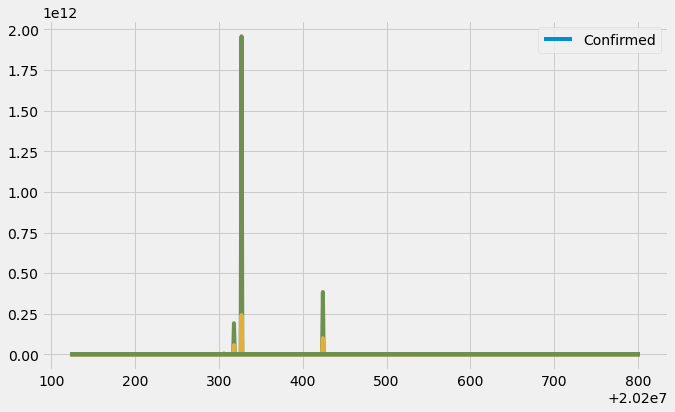

In [29]:
plt.figure(figsize=(10,6))
plt.plot(df_full.set_index('Date'))
plt.legend(['Confirmed'])

In [98]:
df = df_full[["Date", "Daily"]].copy()
df.columns = ["ds", "y"]
df['ds']= pd.to_datetime(df['ds'])
df

,ds,y
0,2020-01-23,1.0
1,2020-01-24,1.0
2,2020-01-25,0.0
3,2020-01-26,3.0
4,2020-01-27,0.0
...,...,...
187,2020-07-28,70776.0
188,2020-07-29,68033.0
189,2020-07-30,67092.0
190,2020-07-31,58485.0


In [108]:
m1 = Prophet()
m1.fit(df)
m1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [103]:
future1 = m1.make_future_dataframe(periods=1)
forecast1 = m1.predict(future1)
forecast1.tail(20).T

,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191
ds,2020-07-13 00:00:00,2020-07-14 00:00:00,2020-07-15 00:00:00,2020-07-16 00:00:00,2020-07-17 00:00:00,2020-07-18 00:00:00,2020-07-19 00:00:00,2020-07-20 00:00:00,2020-07-21 00:00:00,2020-07-22 00:00:00,2020-07-23 00:00:00,2020-07-24 00:00:00,2020-07-25 00:00:00,2020-07-26 00:00:00,2020-07-28 00:00:00,2020-07-29 00:00:00,2020-07-30 00:00:00,2020-07-31 00:00:00,2020-08-01 00:00:00,2020-08-02 00:00:00
trend,54032.3,54689.2,55346.1,56003,56659.9,57316.7,57973.6,58630.5,59287.4,59944.3,60601.2,61258.1,61915,62571.9,63885.7,64542.5,65199.4,65856.3,66513.2,67170.1
yhat_lower,41508.6,44851.6,45038.4,47512.7,48937.2,47116.7,46056.3,45608.2,48253.5,50489.5,51942.2,53165.2,51315.2,50135.5,53191.6,55172.5,57252.1,58034.2,55731.7,54917.4
yhat_upper,61955.9,64629.7,65719.3,68344.6,69826.8,67456.7,66782.3,66741.6,69071.9,71294.1,73063.3,73754.5,72462.9,70811.7,73190.2,74477.9,77701.7,78727.6,76660.9,75698.5
trend_lower,54032.3,54689.2,55346.1,56003,56659.9,57316.7,57973.6,58630.5,59287.4,59944.3,60601.2,61258.1,61915,62571.9,63885.7,64542.5,65199.4,65856.3,66513.2,67170.1
trend_upper,54032.3,54689.2,55346.1,56003,56659.9,57316.7,57973.6,58630.5,59287.4,59944.3,60601.2,61258.1,61915,62571.9,63885.7,64542.5,65199.4,65856.3,66513.2,67170.1
additive_terms,-2484.54,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35,-2484.54,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35
additive_terms_lower,-2484.54,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35,-2484.54,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35
additive_terms_upper,-2484.54,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35,-2484.54,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35
weekly,-2484.54,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35,-2484.54,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35,-398.815,125.803,2358.53,2536.25,-14.8775,-2122.35


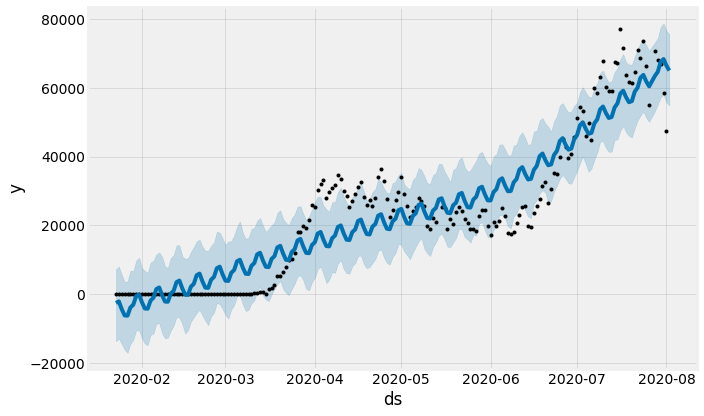

In [112]:
fig = m1.plot(forecast1)
#a = add_changepoints_to_plot(fig.gca(), m1, forecast1)
